#### IMPORT NEEDED PACKAGES


In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns

#### IMPORT DATAFRAME AND PREPROCESS IT

In [13]:
# Load the dataset
data = pd.read_excel("./data/horn_bill_telemetry.xlsx")

# Preprocessing (if not already done)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

# Combine month and year into a single column for better x-axis labeling
data['month_year'] = data['timestamp'].dt.strftime('%B %Y')

#### USE CLUSTERING METHOD TO GROUP DATA(DBSCAN)
1. OPTIMAL K IS FOUND BY ELBOW METHOD
2. CLUSTERING IS DONE BY DBSCAN ALGORITHM
3. CLUSTERING RESULTS ARE STORED IN A DATAFRAME

In [14]:
# Select features for clustering
features = ['location-long', 'location-lat', 'month', 'year']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Based on the Elbow Method, set the optimal number of clusters
optimal_k = 4  # Adjust based on the Elbow Method result
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Extract cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Behavioral Insights: Analyze common locations and times
# Group by cluster, month, and year to understand patterns
behavioral_insights = data.groupby(['cluster', 'month_year']).agg({
    'location-long': 'mean',
    'location-lat': 'mean',
    'timestamp': 'count'
}).reset_index()

behavioral_insights.rename(columns={'timestamp': 'visit_count'}, inplace=True)

# Convert month_year back to datetime for proper sorting
behavioral_insights['month_year'] = pd.to_datetime(behavioral_insights['month_year'], format='%B %Y')

# Sort by 'month_year'
behavioral_insights.sort_values('month_year', inplace=True)

# Save the behavioral insights DataFrame as an Excel file
output_file_path = './insights/behavioral_insights.xlsx'
behavioral_insights.to_excel(output_file_path, index=False)

#'data' has an 'event_id' column
# Add the cluster assignments to the DataFrame
data_with_clusters = data[['event-id','individual-local-identifier','individual-taxon-canonical-name', 'location-long', 'location-lat', 'timestamp', 'cluster']]

# Save the DataFrame with clusters to an Excel file
output_file_with_clusters = './insights/data_with_clusters.xlsx'
data_with_clusters.to_excel(output_file_with_clusters, index=False)

### VISUALIZING CLUSTERS WITH RESPECTIVE CLUSTER CENTERS

In [17]:
# Calculate centroids for each cluster
centroids = data.groupby('cluster').agg({
    'location-long': 'mean',
    'location-lat': 'mean'
}).reset_index()

print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
   cluster  location-long  location-lat
0        0      92.941213     26.954532
1        1      92.992633     27.078903
2        2      92.962285     26.935840
3        3      92.882072     26.915631


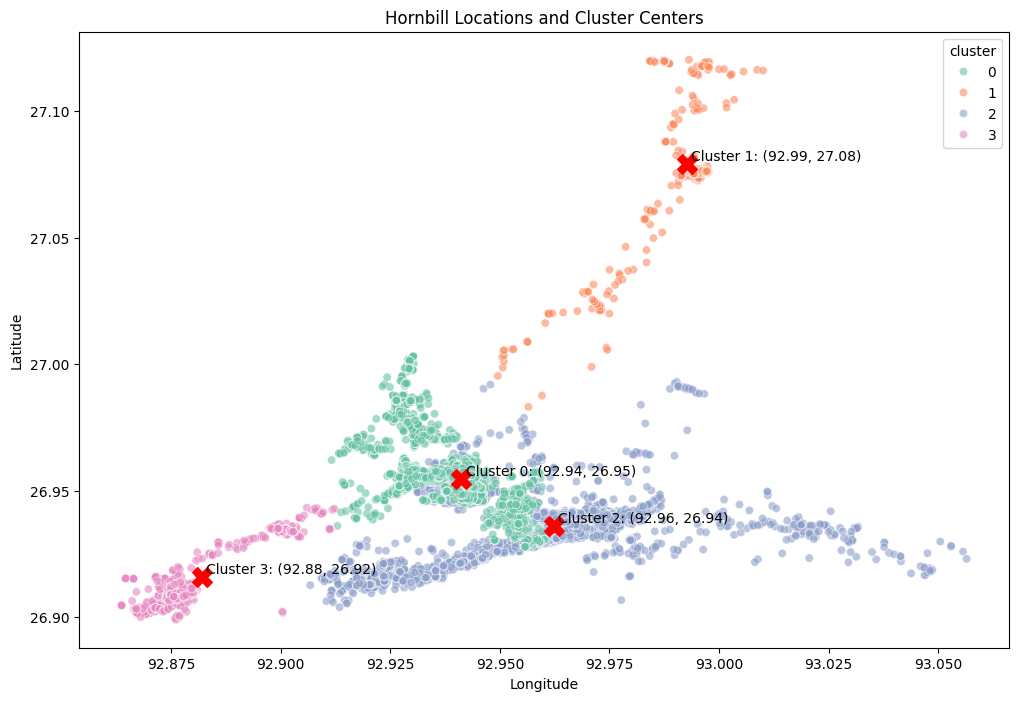

In [15]:
# Visualize the cluster centers on a map using Seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x='location-long', y='location-lat', hue='cluster', palette='Set2', data=data, alpha=0.6)
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], s=200, c='red', marker='X')
    plt.annotate(f'Cluster {i}: ({center[0]:.2f}, {center[1]:.2f})', xy=(center[0], center[1]), xytext=(3, 3), textcoords="offset points")
plt.title('Hornbill Locations and Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### MONTH WISE STAY OF BIRDS IN EACH CLUSTERS
1. USED TO GET INSIGHTS OF WHICH REGIONS ARE ACTIVE DURING BREEDING SEASON

In [16]:
time_per_visit = 7.5  # Each visit is equivalent to 7.5 minutes

# Calculate total time stayed (in minutes) for each cluster and month_year
behavioral_insights['time_stayed'] = behavioral_insights['visit_count'] * time_per_visit/60

# Visualize the distribution of time stayed by month_year for each cluster using Plotly scatter plot
fig = px.scatter(
    behavioral_insights,
    x='month_year',
    y='time_stayed',
    color='cluster',
    title='Hornbill Time Stayed Patterns by Month and Cluster',
    labels={'month_year': 'Month and Year', 'time_stayed': 'Total Time Stayed (Hour)', 'cluster': 'Cluster'},
    color_discrete_sequence=px.colors.qualitative.Plotly
)

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Month and Year',
    yaxis_title='Total Time Stayed (Hour)',
)

# Display interactive plot
fig.show()